In [7]:
from loadTDMS import *
from fft_test import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [2]:
# date = 20211025
# date = 20211115
# date = 20220630
# date = 20221027
# date = 20230113
# date = 20230117
date = 20230120
# date = 20230123

In [10]:
dt = 1/10**6
split_t_r = 0.1 # 1つの枠で全体のどの割合のデータを分析するか。
overlap = 0.5  # オーバーラップ率
window_F = "hamming"  # 窓関数選択: hanning, hamming, blackman
y_label = "amplitude"
y_unit = "V"

In [11]:
def get_tdms(num):
    load_path = rf"Z:\100 Raw_data\{date}---切削実験\AE\Cutting\AE_{num}.tdms"
    d = load_tdms(load_path, ch_num=3)
#     return d[1][36000*3:]
    return d[1][1000000*3:]

## 別々型

In [13]:
for i in tqdm(range(1,461)):
    d = get_tdms(i)
    mensekis = []
    
    for j in range(0,1023):
        sample_num = 2**14
        start = j * 25000
        end = start + sample_num

        ds = d[start:end]
        
        N = len(ds)
        fq = np.linspace(0, N*dt, N)  # 周波数軸　linspace(開始,終了,分割数)
        
        fq_, amp_ = FFT_main(fq, ds, dt, split_t_r, overlap, window_F)
        amp_ = np.array(np.split(20*np.log10(amp_) +100, 10))

        menseki = np.sum(amp_, axis=1)
        mensekis.append(menseki)
    np.save(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\{i}", np.array(mensekis))

  1%|          | 4/460 [01:38<3:07:58, 24.73s/it]


KeyboardInterrupt: 

In [ ]:
for i in tqdm(range(0,10)):
    d1 = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\1.npy")
    d1 = d1.T
    dd = d1[i]
#     print(dd.shape)
    for num in range(2,461):
        d2 = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\{num}.npy")
        d2 = d2.T
        dd = np.concatenate([dd,d2[i]])
#         print(dd.shape)
    start = i * 50
    end = (i+1) *50
    dd = dd.reshape(int(len(dd)/1200),1200)
#     print(dd.shape)
    np.save(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\All{i+1}",dd)

In [3]:
from sklearn import preprocessing

In [4]:
d_min = []
d_max = []
spectrum = []
d_std = []

for i in range(0,10):
    start = i * 50
    end = (i+1) *50

    d = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\All{i+1}.npy")
    d = d.T
    d = d.ravel()
    
    d_min.append(np.min(d))
    d_max.append(np.max(d))
    spectrum.append(f"{start}-{end}")
    
    d = preprocessing.minmax_scale(d)
    d_std.append(np.std(d))

d_min = np.array(d_min)
d_max = np.array(d_max)
d_minmax_diff = d_max - d_min


dict1 = dict(spectrum = spectrum[:] ,min_ = d_min[:], max_ = d_max[:], diff_ = d_minmax_diff[:], d_std = d_std[:])
df1 = pd.DataFrame(data=dict1)
df1.to_csv(rf'Z:\200 Produced_data\{date}\AE\menseki\50khz\EachSpectrumMinMax.csv')


In [5]:
df = pd.read_csv(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\EachSpectrumMinMax.csv")
df

Unnamed: 0 spectrum         min_         max_        diff_     d_std
0           0     0-50  2070.191825  4163.705045  2093.513220  0.015036
1           1   50-100  1768.131084  2240.624368   472.493283  0.100022
2           2  100-150  1244.893308  1915.867844   670.974535  0.084330
3           3  150-200   945.280003  2325.797958  1380.517955  0.114161
4           4  200-250   795.255963  2830.176004  2034.920042  0.204860
5           5  250-300   712.013135  2473.173499  1761.160365  0.160766
6           6  300-350   674.145551  2251.331243  1577.185692  0.123298
7           7  350-400   627.200029  2157.899410  1530.699381  0.062496
8           8  400-450   608.341279  2124.083409  1515.742131  0.038308
9           9  450-500   597.045887  2119.908874  1522.862987  0.037853

100%|██████████| 10/10 [00:40<00:00,  4.07s/it]


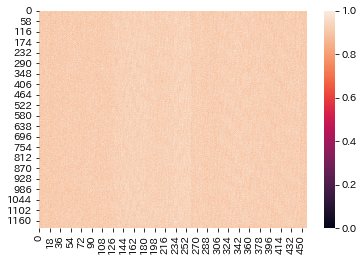

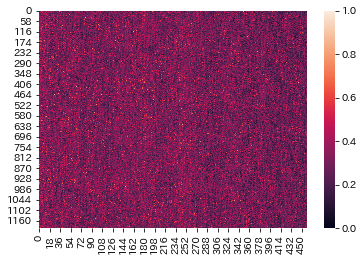

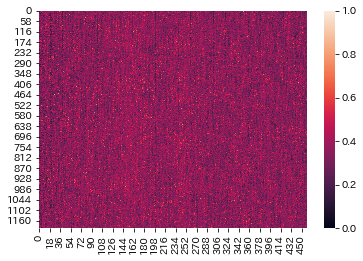

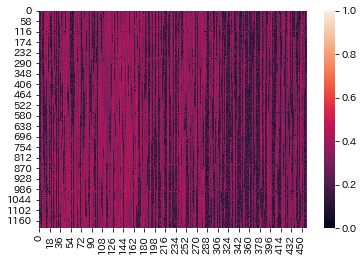

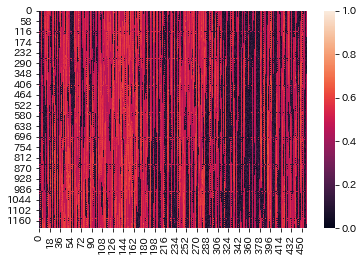

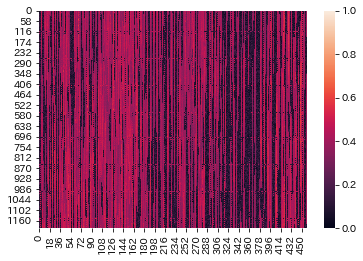

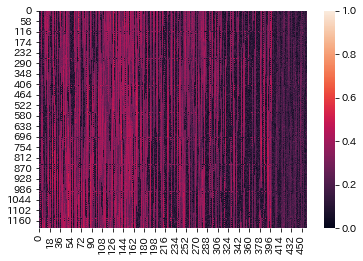

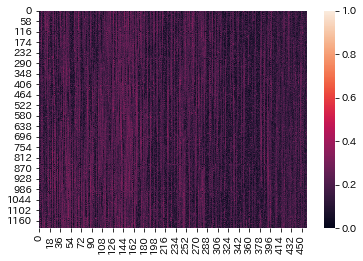

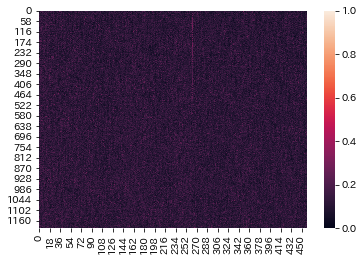

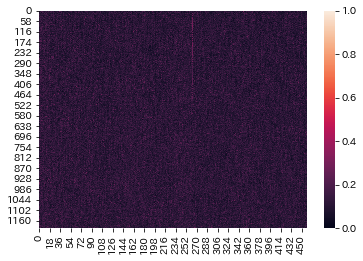

In [10]:
for i in tqdm(range(0,10)):
    figure, ax = plt.subplots()
    d = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\All{i+1}.npy")
    d = d.ravel()
#     print("---------------------")
    d = preprocessing.minmax_scale(d)
#     print(len(d)/169)
    np.save(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\All{i+1}Norm_flatten",d)
#     print(d.shape)
    d = d.reshape(460, int(len(d)/460))
#     print(d.shape)
    np.save(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\All{i+1}_Norm",d)
    sns.heatmap(d.T)
    figure.savefig(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\All{i+1}_Norm.png", dpi=500)

## NO outlier （外れ値除去）

In [133]:
num = 8
norm = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\All{num+1}Norm_flatten.npy")
plt.plot(norm)

In [134]:
norm_n = np.where(norm > 0.6, 2, norm)
index = np.where(norm_n == 2)
d = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\All{num+1}.npy")
d = d.ravel()
d_o = d.copy()
index = index[0]
print(index)
print(d[index])
d[index] = np.average(d)
print(len(index))
plt.plot(d_o)
plt.plot(d)

[ 20400  93600 139200 241200 270000 333600 433200 470400]
[2091.10942109 2068.67338977 1989.64432259 1881.34503272 1982.56653767
 2079.36252124 1884.20317038 2124.08340916]
8


In [135]:
d = d.reshape(int(len(d)/1200),1200)
np.save(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\All{num+1}_NOoutlier",d)

In [118]:
num = 6
norm = np.load(rf"Z:\200 Produced_data\20230117\AE\menseki\50khz\All{num+1}.npy")
plt.plot(norm.ravel())

# NOoutlierで正規化してヒートマップ等再作成

In [137]:
d_min = []
d_max = []
spectrum = []
d_std = []

for i in range(0,10):
    start = i * 50
    end = (i+1) *50

    d = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\NOoutlier\All{i+1}_NOoutlier.npy")
    d = d.T
    d = d.ravel()
    
    d_min.append(np.min(d))
    d_max.append(np.max(d))
    spectrum.append(f"{start}-{end}")
    
    d = preprocessing.minmax_scale(d)
    d_std.append(np.std(d))

d_min = np.array(d_min)
d_max = np.array(d_max)
d_minmax_diff = d_max - d_min


dict1 = dict(spectrum = spectrum[:] ,min_ = d_min[:], max_ = d_max[:], diff_ = d_minmax_diff[:], d_std = d_std[:])
df1 = pd.DataFrame(data=dict1)
df1.to_csv(rf'Z:\200 Produced_data\{date}\AE\menseki\50khz\NOoutlier\EachSpectrumMinMax.csv')

In [138]:
df = pd.read_csv(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\EachSpectrumMinMax.csv")
df

Unnamed: 0 spectrum         min_         max_        diff_     d_std
0           0     0-50  3862.627014  4163.705045   301.078031  0.101934
1           1   50-100  1768.131084  2240.624368   472.493283  0.100022
2           2  100-150  1244.893308  1915.867844   670.974535  0.084330
3           3  150-200   945.280003  1868.100844   922.820841  0.170758
4           4  200-250   795.255963  2293.824334  1498.568372  0.278173
5           5  250-300   712.013135  1859.445549  1147.432415  0.246737
6           6  300-350   674.145551  1910.804268  1236.658717  0.157224
7           7  350-400   627.200029  1290.168299   662.968270  0.144147
8           8  400-450   608.341279  1186.341986   578.000708  0.100134
9           9  450-500   597.045887  1198.512089   601.466202  0.095520

100%|██████████| 10/10 [00:23<00:00,  2.36s/it]


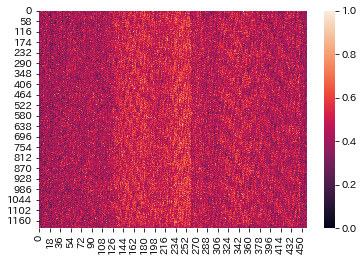

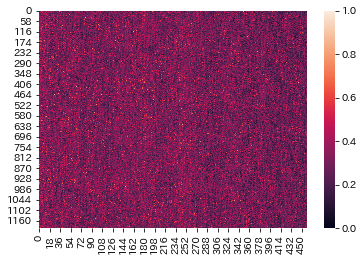

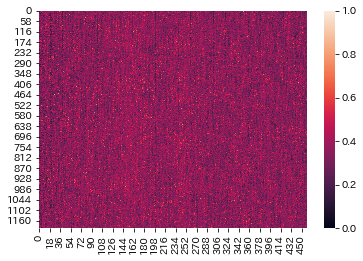

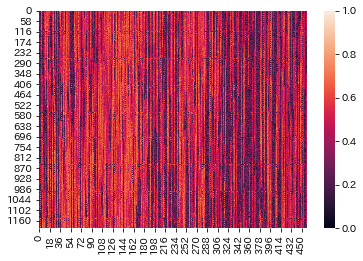

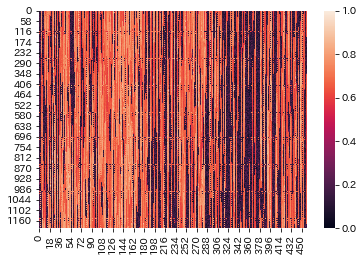

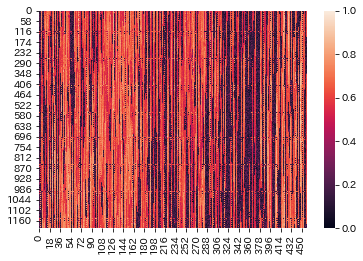

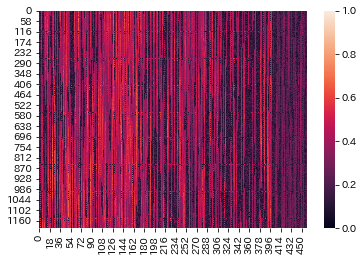

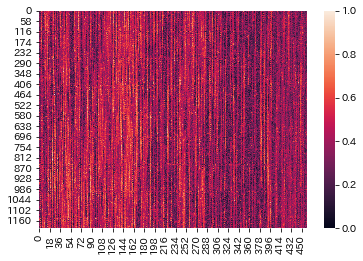

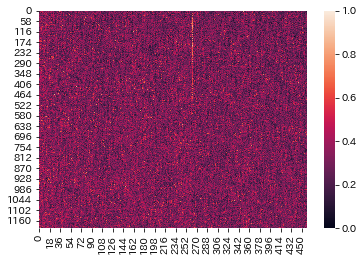

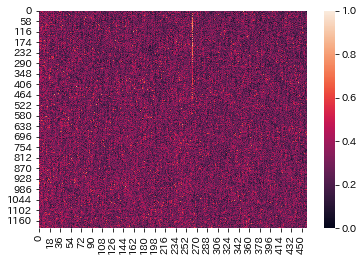

In [141]:
%matplotlib inline
for i in tqdm(range(0,10)):
    figure, ax = plt.subplots()
    d = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\NOoutlier\All{i+1}_NOoutlier.npy")
    d = d.ravel()
#     print("---------------------")
    d = preprocessing.minmax_scale(d)
#     print(len(d)/169)
    np.save(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\NOoutlier\All{i+1}Norm_flatten",d)
#     print(d.shape)
    d = d.reshape(460, int(len(d)/460))
#     print(d.shape)
    np.save(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\NOoutlier\All{i+1}_Norm",d)
    sns.heatmap(d.T)
    figure.savefig(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\NOoutlier\All{i+1}_Norm.png", dpi=500)

In [142]:
#all_path_num
a_p_n = 460
#all_rotation_num
a_r_n = 1200
#moving avg path step
m_a_p_s = 10

w_size = a_r_n*m_a_p_s
x = np.linspace(-1,1,w_size)
v = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
v = v / np.sum(v)
v = np.sort(v)[::-1]

In [143]:
date = 20230120

In [145]:
for num in tqdm(range(0,10)):
    ae = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\NOoutlier\All{num+1}Norm_flatten.npy")
    aem = np.convolve(ae,v, mode='valid')
    np.save(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\NOoutlier\All{num+1}Norm_flatten_MA",aem)

100%|██████████| 10/10 [04:12<00:00, 25.24s/it]


In [149]:
cfm = np.load(rf"Z:\200 Produced_data\20230120\CF\max8308\All_MA_n.npy")

In [150]:
date

20230120

# 1-460

100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


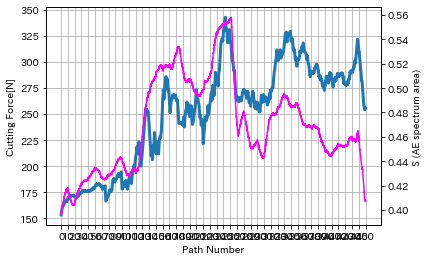

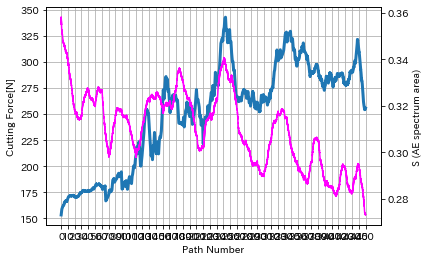

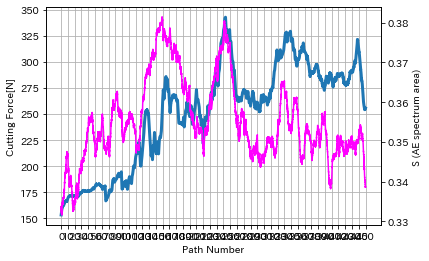

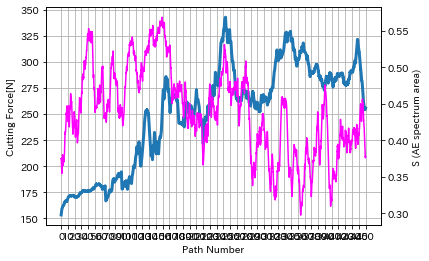

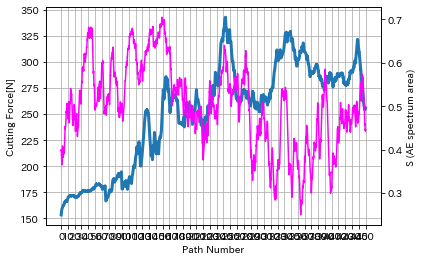

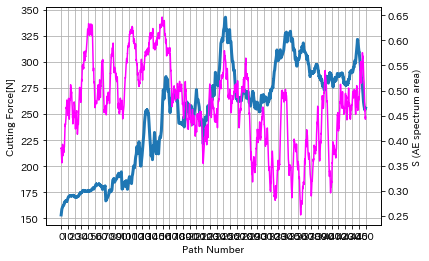

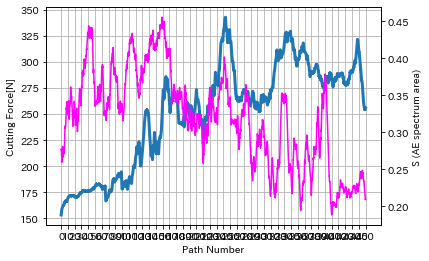

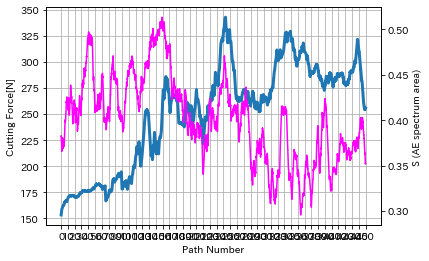

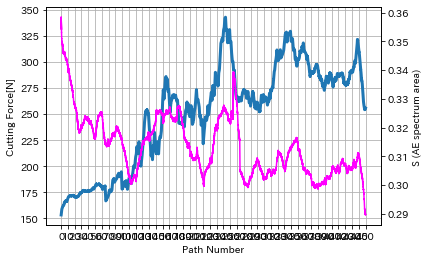

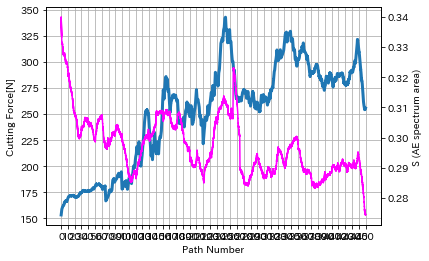

In [154]:
# %matplotlib qt

#all_path_num
a_p_n = 460
#all_rotation_num
a_r_n = 1200
#moving avg path step
m_a_p_s = 10

w_size = a_r_n*m_a_p_s
x = np.linspace(-1,1,w_size)
v = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
v = v / np.sum(v)
v = np.sort(v)[::-1]


correlation_list = []
spectrum = []


for i in tqdm(range(0,10)):
    aem = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\NOoutlier\All{i+1}Norm_flatten_MA.npy")
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_xticks(np.arange(1, a_p_n*a_r_n, a_r_n*m_a_p_s))
    ax.set_xticklabels(np.arange(0,a_p_n,m_a_p_s))
    ax.set_xlabel(xlabel='Path Number')
    ax.set_ylabel(ylabel='S (AE spectrum area)')
    ax.set_ylabel(ylabel='Cutting Force[N]')
    ax.tick_params(axis = 'x')
    ax.tick_params(axis = 'y')
    ax2 = ax.twinx()
    ax2.set_ylabel(ylabel='S (AE spectrum area)')
    ax.grid()
    ax.plot(cfm, lineWidth="3", label="cutting force")
    ax2.plot(aem, color="magenta")
    plt.savefig(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\NOoutlier\cf_and_S{i+1}.png")
    correlation = np.corrcoef(cfm, aem)
    correlation_list.append(correlation[0][1])
    start = i * 50
    end = (i+1) *50
    spectrum.append(f"{start}-{end}")

dict1 = dict(spectrum = spectrum[:] , corr = correlation_list[:])
df1 = pd.DataFrame(data=dict1)
df1.to_csv(rf'Z:\200 Produced_data\{date}\AE\menseki\50khz\NOoutlier\EachSpectrumCorrelationWithCF_movingAVG(10path).csv')

In [155]:
df = pd.read_csv(rf"Z:\200 Produced_data\20230120\AE\menseki\50khz\NOoutlier\EachSpectrumCorrelationWithCF_movingAVG(10path).csv")
df

Unnamed: 0 spectrum      corr
0           0     0-50  0.603366
1           1   50-100 -0.366970
2           2  100-150  0.264293
3           3  150-200 -0.404802
4           4  200-250 -0.396449
5           5  250-300 -0.408649
6           6  300-350 -0.498642
7           7  350-400 -0.470341
8           8  400-450 -0.396597
9           9  450-500 -0.352105

# 1-120

In [156]:
cfm = np.load(rf"Z:\200 Produced_data\20230120\CF\max8308\All_MA_n.npy")
cfm = cfm[:120*1200]

In [ ]:
# %matplotlib qt

#all_path_num
a_p_n = 120
#all_rotation_num
a_r_n = 1200
#moving avg path step
m_a_p_s = 10

w_size = a_r_n*m_a_p_s
x = np.linspace(-1,1,w_size)
v = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
v = v / np.sum(v)
v = np.sort(v)[::-1]


correlation_list = []
spectrum = []


for i in tqdm(range(0,10)):
    aem = np.load(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\NOoutlier\All{i+1}Norm_flatten_MA.npy")
    aem = aem[:120*1200]
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_xticks(np.arange(1, a_p_n*a_r_n, a_r_n*m_a_p_s))
    ax.set_xticklabels(np.arange(0,a_p_n,m_a_p_s))
    ax.set_xlabel(xlabel='Path Number')
    ax.set_ylabel(ylabel='S (AE spectrum area)')
    ax.set_ylabel(ylabel='Cutting Force[N]')
    ax.tick_params(axis = 'x')
    ax.tick_params(axis = 'y')
    ax2 = ax.twinx()
    ax2.set_ylabel(ylabel='S (AE spectrum area)')
    ax.grid()
    ax.plot(cfm, lineWidth="3", label="cutting force")
    ax2.plot(aem, color="magenta")
    plt.savefig(rf"Z:\200 Produced_data\{date}\AE\menseki\50khz\NOoutlier\_1-120_cf_and_S{i+1}.png")
    correlation = np.corrcoef(cfm, aem)
    correlation_list.append(correlation[0][1])
    start = i * 50
    end = (i+1) *50
    spectrum.append(f"{start}-{end}")

dict1 = dict(spectrum = spectrum[:] , corr = correlation_list[:])
df1 = pd.DataFrame(data=dict1)
df1.to_csv(rf'Z:\200 Produced_data\{date}\AE\menseki\50khz\EachSpectrumCorrelationWithCF_movingAVG(10path).csv')

# 121-460